In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing data from CSV file

In [2]:
df = pd.read_csv('telecom_churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [4]:
df['Churn'].value_counts()

0    2850
1     483
Name: Churn, dtype: int64

- As we can see, we have an unbalanced target

### Plotting a correlation Matrix to find the correlation between variables

<AxesSubplot:>

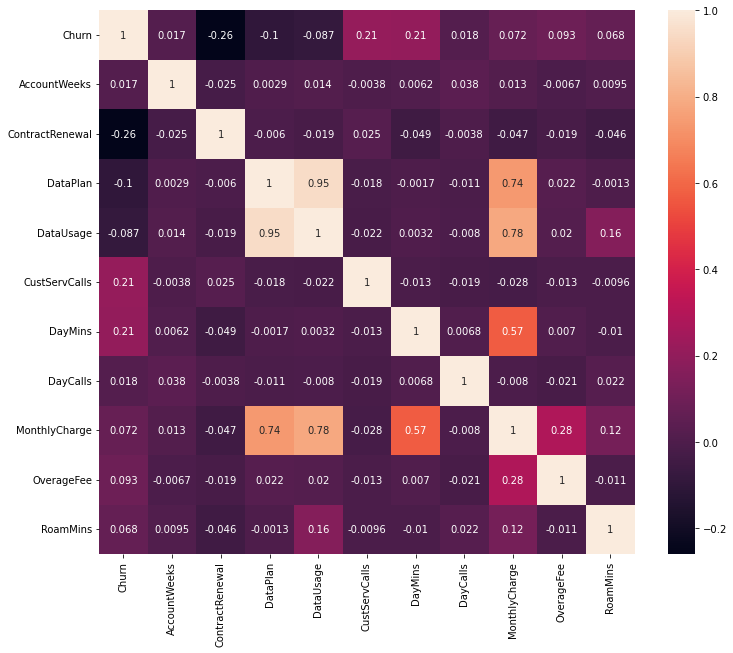

In [5]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True)

- RoamMins has a correlation with DataUsage, because the effect of using data Roaming services causes customers to use more internet data

<AxesSubplot:xlabel='ContractRenewal', ylabel='count'>

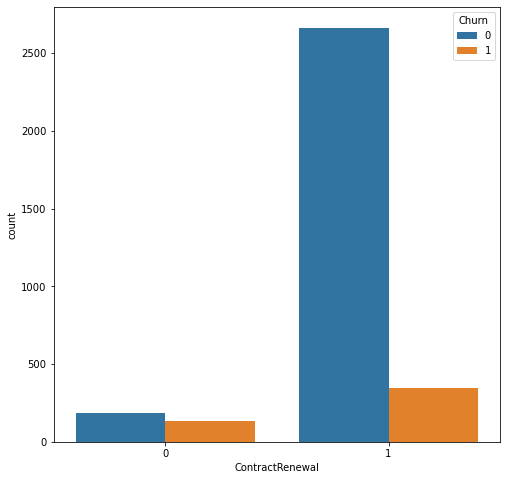

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(data=df, x='ContractRenewal', hue='Churn')

- It's possible to see that the contract extension can affect a small number of customers to churn

<AxesSubplot:xlabel='DataPlan', ylabel='count'>

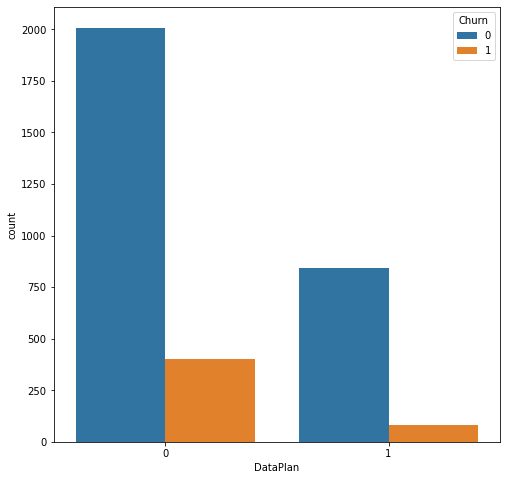

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(data=df, x='DataPlan', hue='Churn')

- Customers who do not use a data plan are more likely to churn

<AxesSubplot:xlabel='CustServCalls', ylabel='count'>

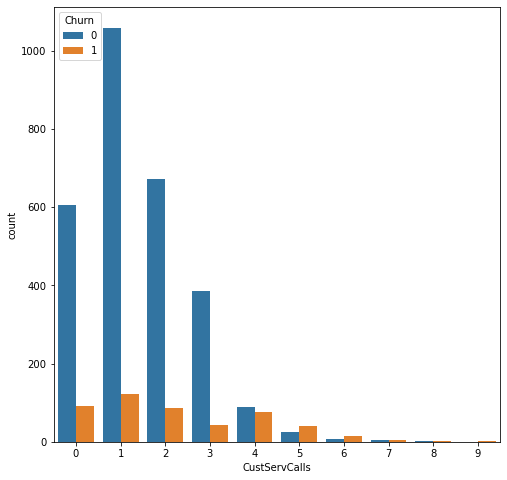

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(data=df, x='CustServCalls', hue='Churn')

- Most customers who churn are customers who receive 1 call from customer service

array([[<AxesSubplot:title={'center':'AccountWeeks'}>,
        <AxesSubplot:title={'center':'DataUsage'}>,
        <AxesSubplot:title={'center':'DayCalls'}>],
       [<AxesSubplot:title={'center':'MonthlyCharge'}>,
        <AxesSubplot:title={'center':'OverageFee'}>,
        <AxesSubplot:title={'center':'RoamMins'}>]], dtype=object)

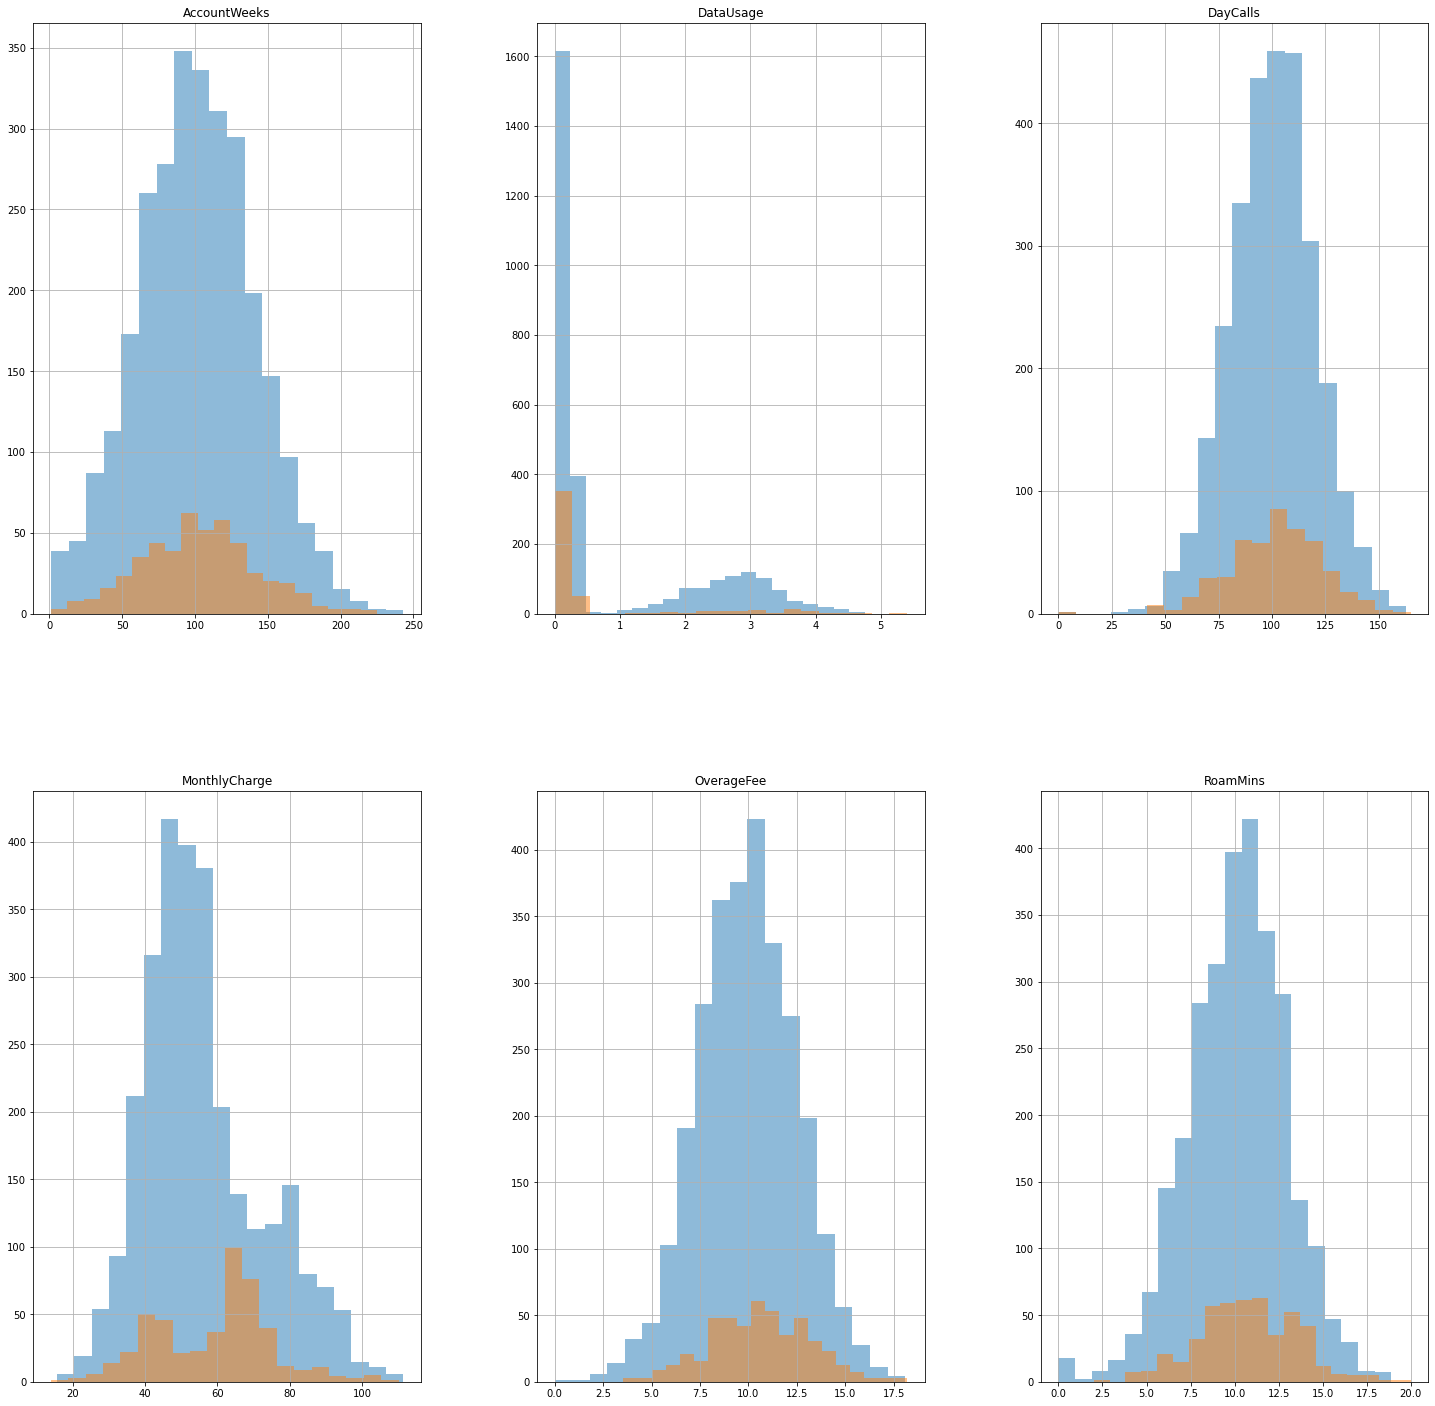

In [9]:
from matplotlib import pyplot as plt
import numpy as np
numerical_features = ['AccountWeeks','DataUsage','DayCalls','MonthlyCharge','OverageFee','RoamMins']
fig, ax = plt.subplots(2, 3, figsize=(25, 25))
df[df.Churn == 0][numerical_features].hist(bins=20, alpha=0.5, ax=ax)
df[df.Churn == 1][numerical_features].hist(bins=20, alpha=0.5, ax=ax)

### Informations that It's posible to see above:
- In the AccountWeeks column, customers who have an account with 100 weeks tend to churn
- In the DataUsage column, customers who churn are customers who do not use a data plan
- In the DayCalls column, customers who make calls with an average of 100 calls tend to churn
- In the MonthlyCharge column, customers with an average monthly bill of 65 - 70 dollars tend to churn
- In the OverageFee column, customers who are charged are more likely to churn
- In the RoamMins column, Customers who use roaming services for 8 - 13 minutes tend to churn

# Spliting the data

In [10]:
from sklearn.model_selection import train_test_split

X = df.drop('Churn',axis=1)
y = df.Churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)
X_train.head()

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
1680,107,1,0,0.00,2,194.5,97,49.0,9.32,12.7
81,116,0,0,0.30,3,215.4,104,58.0,10.24,12.6
151,117,1,0,0.00,1,102.8,119,36.0,10.34,10.1
774,80,1,0,0.00,1,161.1,99,45.0,9.94,10.6
790,92,0,1,2.03,0,281.1,88,85.3,9.90,7.5


# Resampling
---
### ***Never resample the data without splitting them in train/test! It will have substantial data leakage!!!***

---
- To improve the performance of the model, the data should be balanced first

In [11]:
from sklearn.utils import resample

#upsample the minority class
X_train_upsampled, y_train_upsampled = resample(X_train[y_train == 1],
                                        y_train[y_train == 1],
                                        replace=True,
                                        n_samples=len(y_train[y_train == 0]),
                                        random_state=42)

#concatenating with unbalanced data
X_train_upsampled = pd.concat([X_train_upsampled, X_train[y_train == 0]])
y_train_upsampled = pd.concat([y_train_upsampled, y_train[y_train == 0]])

In [12]:
y_train_upsampled.value_counts()

1    2281
0    2281
Name: Churn, dtype: int64

# Testing models

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

def get_scores(model):
        model = model()
        model = model.fit(X_train_upsampled, y_train_upsampled)
        predicted_values = model.predict(X_test)
        
        print('Classification report \n\n', classification_report(y_test, predicted_values))

        plot_confusion_matrix(model, X_test, y_test)
        plt.title(f'Confusion Matrix Model')
        plt.xticks([0,1],['Not churned','Churned'])
        plt.yticks([0,1],['Not churned','Churned'])

Classification report 

               precision    recall  f1-score   support

           0       0.94      0.75      0.83       569
           1       0.33      0.70      0.45        98

    accuracy                           0.75       667
   macro avg       0.63      0.73      0.64       667
weighted avg       0.85      0.75      0.78       667



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


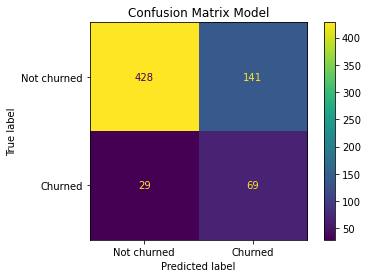

In [14]:
from sklearn.linear_model import LogisticRegression

get_scores(LogisticRegression)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classification report 

               precision    recall  f1-score   support

           0       0.94      0.93      0.93       569
           1       0.60      0.63      0.62        98

    accuracy                           0.88       667
   macro avg       0.77      0.78      0.77       667
weighted avg       0.89      0.88      0.89       667



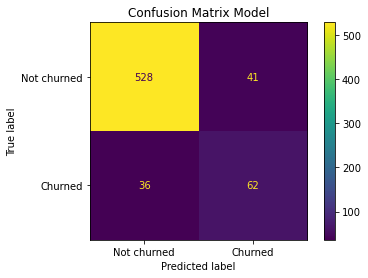

In [15]:
from sklearn.tree import DecisionTreeClassifier

get_scores(DecisionTreeClassifier)

Classification report 

               precision    recall  f1-score   support

           0       0.95      0.96      0.96       569
           1       0.77      0.69      0.73        98

    accuracy                           0.93       667
   macro avg       0.86      0.83      0.84       667
weighted avg       0.92      0.93      0.92       667



/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


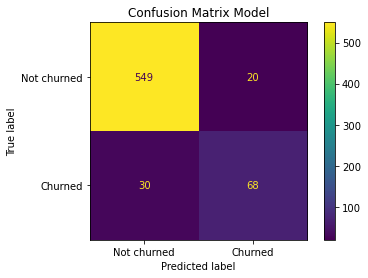

In [16]:
from sklearn.ensemble import RandomForestClassifier

get_scores(RandomForestClassifier)

Classification report 

               precision    recall  f1-score   support

           0       0.90      0.90      0.90       569
           1       0.44      0.45      0.44        98

    accuracy                           0.83       667
   macro avg       0.67      0.67      0.67       667
weighted avg       0.84      0.83      0.83       667



/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


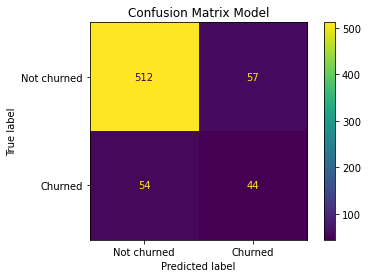

In [17]:
from sklearn.svm import SVC

get_scores(SVC)

Classification report 

               precision    recall  f1-score   support

           0       0.92      0.72      0.81       569
           1       0.28      0.62      0.38        98

    accuracy                           0.71       667
   macro avg       0.60      0.67      0.60       667
weighted avg       0.82      0.71      0.74       667



/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


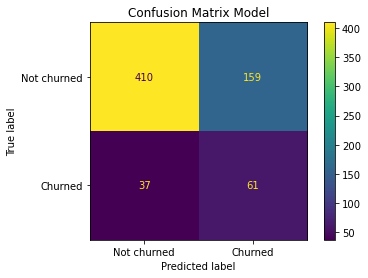

In [18]:
from sklearn.neighbors import KNeighborsClassifier

get_scores(KNeighborsClassifier)

Classification report 

               precision    recall  f1-score   support

           0       0.95      0.84      0.89       569
           1       0.45      0.77      0.56        98

    accuracy                           0.83       667
   macro avg       0.70      0.80      0.73       667
weighted avg       0.88      0.83      0.84       667



/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


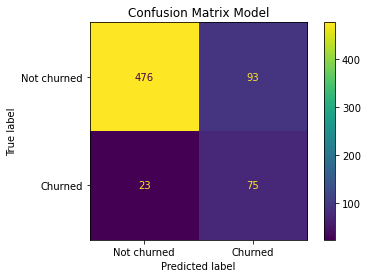

In [19]:
from sklearn.naive_bayes import GaussianNB

get_scores(GaussianNB)

Classification report 

               precision    recall  f1-score   support

           0       0.96      0.92      0.94       569
           1       0.62      0.79      0.69        98

    accuracy                           0.90       667
   macro avg       0.79      0.85      0.81       667
weighted avg       0.91      0.90      0.90       667



/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


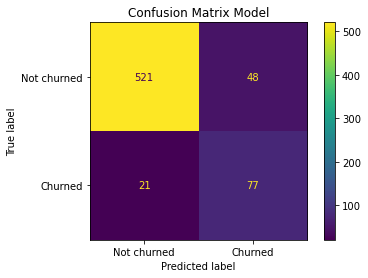

In [20]:
from sklearn.ensemble import GradientBoostingClassifier 

get_scores(GradientBoostingClassifier)

# Fine-tuning

- As we saw above, the best model was Random Forest. So let's try to improve it a little more

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train_upsampled, y_train_upsampled)

In [22]:
from sklearn.model_selection import GridSearchCV

hyperparams = {
    'max_depth':[2,3,5,10,20],
    'min_samples_leaf':[5,10,20,50,100,200],
    'n_estimators':[10,25,30,50,100,200]
}

# Fine-tuning parameters to find the best model
grid_search = GridSearchCV(estimator = rf_model, param_grid = hyperparams, cv = 5, n_jobs = 8, scoring = 'accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=8,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy')

In [23]:
# Model parameters that had the best accuracy
grid_search.best_params_

{'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 50}

# Final Model

In [24]:
# Creating a new instance of RandomForest with the best parameters
rf_best = grid_search.best_estimator_
rf_model = rf_best.fit(X_train, y_train)
rf_predicted = rf_model.predict(X_test)

Classification report 

               precision    recall  f1-score   support

           0       0.94      0.98      0.96       569
           1       0.88      0.66      0.76        98

    accuracy                           0.94       667
   macro avg       0.91      0.82      0.86       667
weighted avg       0.93      0.94      0.93       667



/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


([<matplotlib.axis.YTick at 0x7fc4105ece80>,
 [Text(0, 0, 'Not churned'), Text(0, 1, 'Churned')])

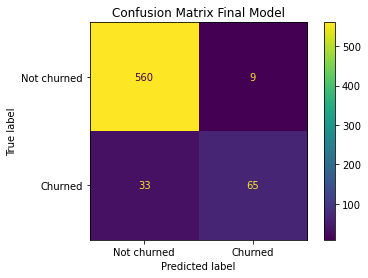

In [25]:
# Getting the performance of the final model

print('Classification report \n\n', classification_report(y_test, rf_predicted))

plot_confusion_matrix(rf_model, X_test, y_test)
plt.title(f'Confusion Matrix Final Model')
plt.xticks([0,1],['Not churned','Churned'])
plt.yticks([0,1],['Not churned','Churned'])